In [1]:
!pip install mediapipe -q
!pip install opencv-python -q
!pip install scikit-learn -q
!pip install wurlitzer -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.3 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-automl 1.0.1 requires google-api-core[grpc]<2.0.0dev,>=1.14.0, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires protobuf<4.0.0dev,>=3.12.0, but y

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from torch.utils.data import Dataset, DataLoader


2024-07-13 19:02:27.143606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 19:02:27.143714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 19:02:27.285279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader


class HandKeypointDataset(Dataset):
    def __init__(self, csv_file, data_dir, label_map):
        self.data_frame = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.label_map = label_map

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        video_id = row['video_id']
        label = row['label']
        frames = np.load(os.path.normpath(os.path.join(self.data_dir, f'{video_id}.npy')))
        label_idx = self.label_map[label]
        return torch.tensor(frames, dtype=torch.float32), torch.tensor(label_idx, dtype=torch.long)


# 标签编码
labels = pd.read_csv('/kaggle/input/hand-gesture-labels/Train.csv')['label'].unique()
label_map = {label: idx for idx, label in enumerate(labels)}


# 创建数据集和数据加载器
train_dataset = HandKeypointDataset('/kaggle/input/hand-gesture-labels/Train.csv', '/kaggle/input/hand-gesture/processed_train/processed_train', label_map)
validation_dataset = HandKeypointDataset('/kaggle/input/hand-gesture-labels/Validation.csv', '/kaggle/input/hand-gesture/processed_validation/processed_validation', label_map)
test_dataset = HandKeypointDataset('/kaggle/input/motion-test-labels/Test_new.csv', '/kaggle/input/hand-gesture-test/processed_test', label_map)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [4]:
class HandGestureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(HandGestureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = self.fc2(x)
        return x


In [5]:
import itertools
import numpy as np
from sklearn.model_selection import ParameterGrid

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        torch.save(model.state_dict(), path)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Using device: cuda
CUDA Available: True
Number of GPUs: 1
Current GPU: 0
GPU Name: Tesla P100-PCIE-16GB


In [7]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(f'Using device: {device}')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='inference_feedback_manager')

# 或者将特定模块的日志级别设为 ERROR
import logging
logging.getLogger('inference_feedback_manager').setLevel(logging.ERROR)


# 创建数据集和数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 检查数据样本
for inputs, labels in train_loader:
    print("Input shape:", inputs.shape)
    print("Label shape:", labels.shape)
    break

# 模型参数
input_size = 21 * 3
hidden_size = 128  # 增加隐藏层大小
output_size = len(label_map)
num_layers = 3  # 增加 LSTM 层数

# 初始化模型、损失函数和优化器
model = HandGestureLSTM(input_size, hidden_size, output_size, num_layers=num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练函数
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs, early_stopping, model_path='best_model.pth', log_each_epoch=True, show_progress=True):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # 使用 tqdm 添加进度条
        if show_progress:
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        else:
            progress_bar = train_loader
        # progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if show_progress:
                progress_bar.set_postfix(loss=f'{loss.item():.4f}', accuracy=f'{(correct / total) * 100:.2f}%')
        
            # 更新进度条显示
            # progress_bar.set_postfix(loss=f'{loss.item():.4f}', accuracy=f'{(correct / total) * 100:.2f}%')

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        if log_each_epoch:
            print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        # print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

        # 验证部分
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(validation_loader.dataset)
        val_losses.append(epoch_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        if log_each_epoch:
            print(f'Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        
        #print(f'Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        early_stopping(epoch_loss, model, model_path)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load(model_path))
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# 初始化 EarlyStopping
early_stopping = EarlyStopping(patience=5, delta=0.01)


Using device: cuda
Input shape: torch.Size([32, 37, 63])
Label shape: torch.Size([32])


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, data_loader, label_map, show_confusion_matrix=True):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    if show_confusion_matrix:
        # 绘制混淆矩阵
        cm = confusion_matrix(all_labels, all_predictions, labels=list(label_map.values()))
        fig, ax = plt.subplots(figsize=(15, 15))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
        plt.show()

    return accuracy, precision, recall, f1



In [9]:
# # 定义超参数范围
# param_grid = {
#     'hidden_size': [64, 128, 256],
#     'num_layers': [1, 2, 3],
#     'learning_rate': [0.01, 0.001, 0.0001]
# }

# # 搜索最佳超参数
# best_score = 0
# best_params = None
# for params in ParameterGrid(param_grid):
#     hidden_size = params['hidden_size']
#     num_layers = params['num_layers']
#     learning_rate = params['learning_rate']
    
#     model = HandGestureLSTM(input_size, hidden_size, output_size, num_layers=num_layers).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
#     early_stopping = EarlyStopping(patience=5, delta=0.01)
#     model = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=50, early_stopping=early_stopping, log_each_epoch=False, show_progress=False)
    
#     # 在验证集上评估模型
#     val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, validation_loader, label_map, show_confusion_matrix=False)
    
#     if val_accuracy > best_score:
#         best_score = val_accuracy
#         best_params = params
        
#     # 显示当前参数集的结果
#     print(f'Params: {params}, Validation Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}')
#     print('\n')

# print(f'Best parameters: {best_params}, Best accuracy: {best_score}')


Train Loss: 2.7050, Train Accuracy: 0.2016
Validation Loss: 2.1614, Validation Accuracy: 0.3644


Train Loss: 1.6403, Train Accuracy: 0.5185
Validation Loss: 1.3622, Validation Accuracy: 0.6047


Train Loss: 1.2435, Train Accuracy: 0.6459
Validation Loss: 1.1285, Validation Accuracy: 0.6789


Train Loss: 1.0901, Train Accuracy: 0.6930
Validation Loss: 1.0647, Validation Accuracy: 0.7033


Train Loss: 0.9960, Train Accuracy: 0.7205
Validation Loss: 1.0111, Validation Accuracy: 0.7176


Train Loss: 0.9425, Train Accuracy: 0.7375
Validation Loss: 0.9734, Validation Accuracy: 0.7233


Train Loss: 0.8922, Train Accuracy: 0.7517
Validation Loss: 0.9342, Validation Accuracy: 0.7361


Train Loss: 0.8598, Train Accuracy: 0.7583
Validation Loss: 0.9204, Validation Accuracy: 0.7406


Train Loss: 0.8340, Train Accuracy: 0.7678
Validation Loss: 0.9461, Validation Accuracy: 0.7339


Train Loss: 0.8104, Train Accuracy: 0.7725
Validation Loss: 0.9154, Validation Accuracy: 0.7439


Train Loss: 0.7891, Train Accuracy: 0.7792
Validation Loss: 0.8796, Validation Accuracy: 0.7542


Train Loss: 0.7681, Train Accuracy: 0.7852
Validation Loss: 0.8477, Validation Accuracy: 0.7599


Train Loss: 0.7549, Train Accuracy: 0.7881
Validation Loss: 0.8715, Validation Accuracy: 0.7502


Train Loss: 0.7392, Train Accuracy: 0.7931
Validation Loss: 0.8547, Validation Accuracy: 0.7602


Train Loss: 0.7289, Train Accuracy: 0.7955
Validation Loss: 0.9640, Validation Accuracy: 0.7372


Train Loss: 0.7122, Train Accuracy: 0.7992
Validation Loss: 0.8777, Validation Accuracy: 0.7554


Train Loss: 0.7043, Train Accuracy: 0.7999
Validation Loss: 0.8652, Validation Accuracy: 0.7609
Early stopping


NameError: name 'num_epochs' is not defined

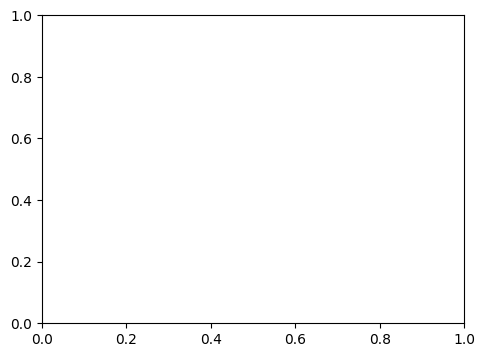

In [10]:
# 使用最佳参数来训练最终模型
# best_hidden_size = best_params['hidden_size']
# best_num_layers = best_params['num_layers']
# best_learning_rate = best_params['learning_rate']

best_hidden_size = 128
best_num_layers = 3
best_learning_rate = 0.001

model = HandGestureLSTM(input_size, best_hidden_size, output_size, num_layers=best_num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)
early_stopping = EarlyStopping(patience=5, delta=0.01)

model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, validation_loader, criterion, optimizer, num_epochs=50, early_stopping=early_stopping, log_each_epoch=True, show_progress=True
    )




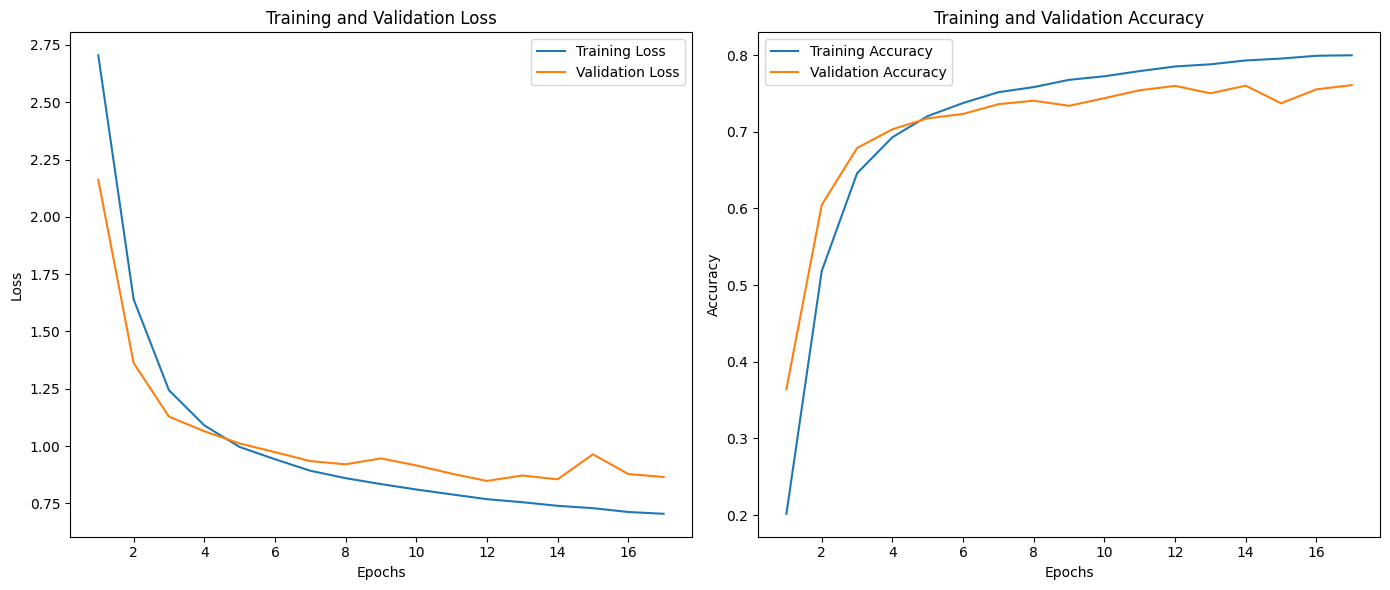

In [14]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    
# 绘制训练和验证损失及准确率曲线
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.7609
Precision: 0.8324
Recall: 0.7609
F1 Score: 0.7838


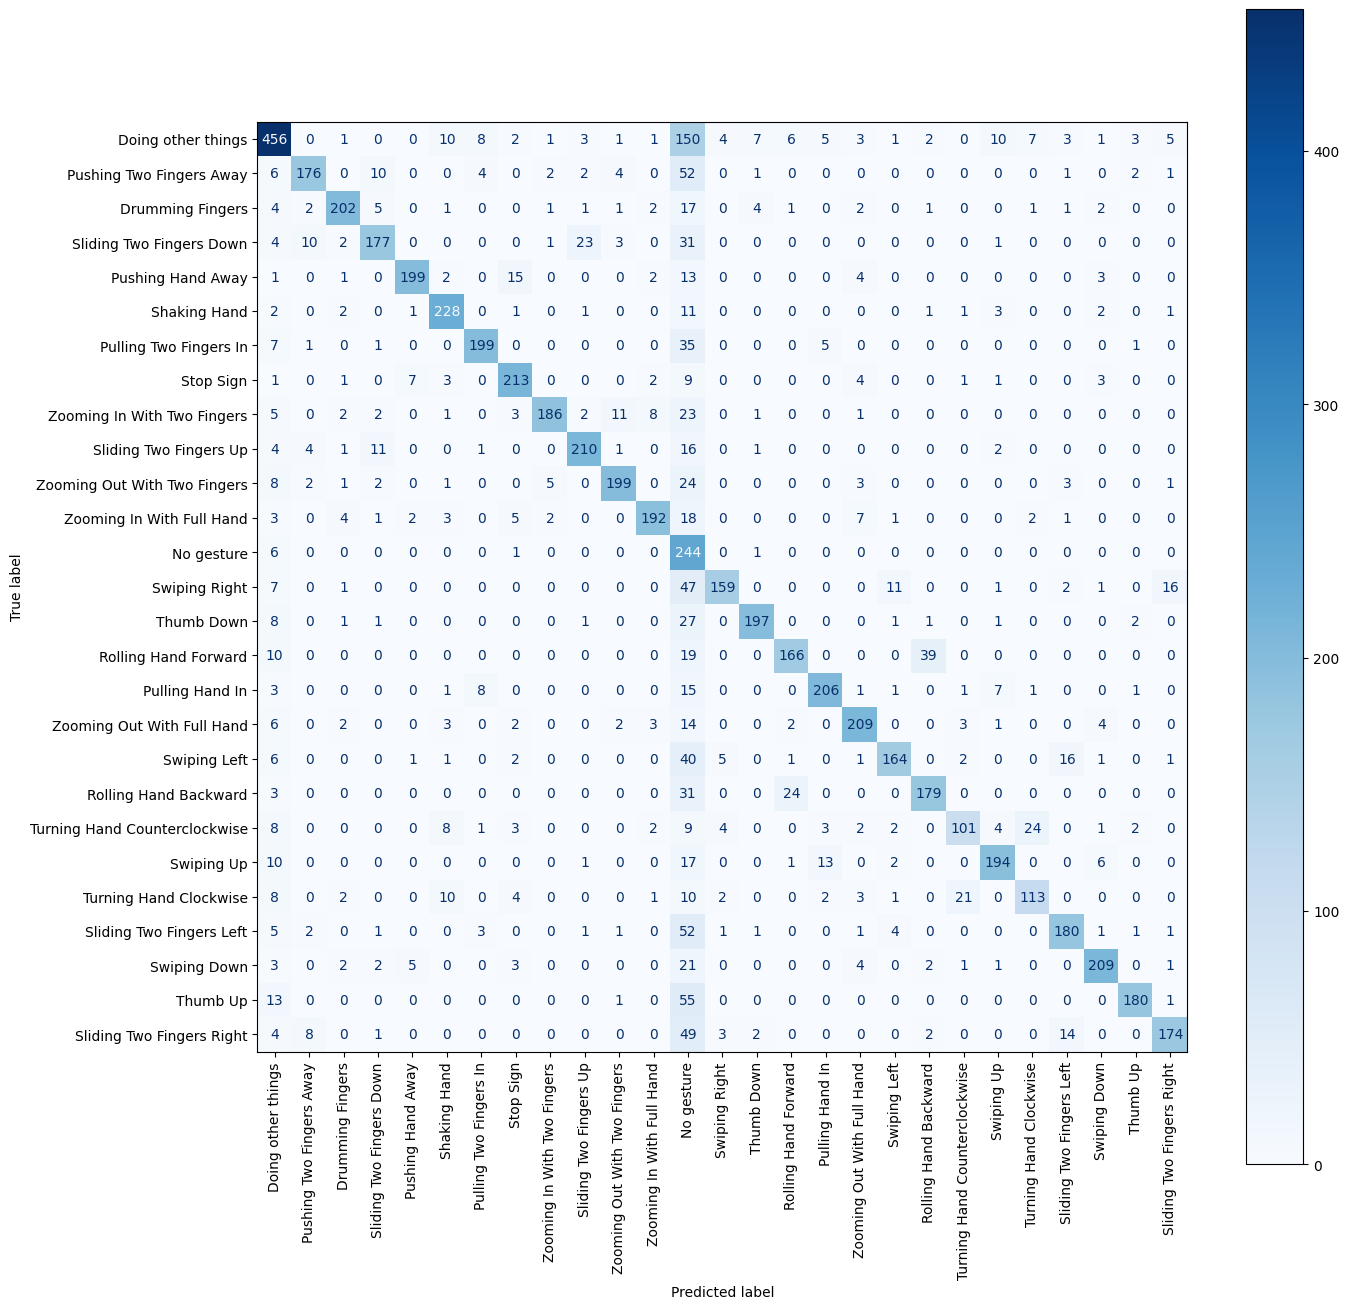

Test Accuracy: 0.7609225039392638, Precision: 0.8323651296962173, Recall: 0.7609225039392638, F1 Score: 0.783760456628831


In [17]:
# 在测试集上评估最终模型
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, label_map, show_confusion_matrix=True)
print(f'Test Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}')
